# Investigating NaN Outputs

The Basic Capsnet model is supposed to act as a proof of concept audio capsule model, but training of these models has repeatedly resulted in the cost function returning nan after less than one epoch of training.

In [30]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import importlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
from SegCaps import capsule_layers
from keras import layers

import audio_functions as af
import model_functions as mf
import audio_models
import dataset

In [13]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

### Get the variables and data ready

In [98]:
#  Set variables
sample_rate=8192
n_fft=1024
fft_hop=256
patch_window=128
patch_hop=64
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002

#checkpoint = '52/52-10' #  Best U-net
checkpoint = '88/88-1'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)

#  Create the iterator
pipeline = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipeline.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

data

<PrefetchDataset shapes: ((?, 128, 513, 2), (?, 128, 513, 2), (?, 32512, 1), (?, 32512, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [3]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                                    voice_audio, 'basic_capsnet', is_training, learning_rate, name='U_Net_Model')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [4]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/88/88-1


### Run a batch

In [5]:
mix_mag, mix_phase, voice_mag, voice_est_mag, mask, voice_wave, mix_wave = sess.run([model.mixed_mag, 
                                                                                     model.mixed_phase, 
                                                                                     model.voice_mag,
                                                                                     model.gen_voice, 
                                                                                     model.voice_mask, 
                                                                                     model.voice_audio, 
                                                                                     model.mixed_audio],
                                                                                    {model.is_training:False})
voice_est_wave = list()

for i in range(voice_mag.shape[0]):
    voice_est_wave.append(af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T))


In [9]:
tf.trainable_variables()

[<tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/Convolution/conv2d/kernel:0' shape=(5, 5, 1, 128) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/Convolution/conv2d/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/Primary_Caps/primarycaps/W:0' shape=(5, 5, 128, 64) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/Primary_Caps/primarycaps/b:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/Seg_Caps/seg_caps/W:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/Seg_Caps/seg_caps/b:0' shape=(1, 1, 1, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/Reconstruction/reconstruction/W:0' shape=(1, 1, 8, 1) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/Reconstruction/reconstruction/b:0' shape=(1, 1, 1, 1) dtype=float32_ref>]

In [49]:
class MagnitudeModel(object):
    """
    Top level U-Net object.
    Attributes:
        mixed_mag: Input placeholder for magnitude spectrogram of mixed signals (voice plus background noise) - X
        voice_mag: Input placeholder for magnitude spectrogram of isolated voice signal - Y
        mixed_phase: Input placeholder for phase spectrogram of mixed signals (voice plus background noise)
        mixed_audio: Input placeholder for waveform audio of mixed signals (voice plus background noise)
        voice_audio: Input placeholder for waveform audio of isolated voice signal
        variant: The type of U-Net model (Normal convolutional or capsule based)
        is_training: Boolean - should the model be trained on the current input or not
        name: Model instance name
    """
    def __init__(self, mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, variant, is_training, learning_rate,
                 name):
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.voice_mag = voice_mag
            self.mixed_phase = mixed_phase
            self.mixed_audio = mixed_audio
            self.voice_audio = voice_audio
            self.variant = variant
            self.is_training = is_training

            if self.variant in ['unet', 'capsunet']:
                self.voice_mask_network = UNet(mixed_mag, variant, is_training=is_training, reuse=False, name='voice-mask-unet')
            elif self.variant == 'basic_capsnet':
                self.voice_mask_network = BasicCapsnet(mixed_mag, name='CapsNetBasic')

            self.voice_mask = self.voice_mask_network.output

            self.gen_voice = self.voice_mask * mixed_mag

            self.cost = mf.l1_loss(self.gen_voice, voice_mag)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=learning_rate,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.cost)

class BasicCapsnet(object):

    def __init__(self, mixed_mag, name):
        """
        input_tensor: Tensor with shape [batch_size, height, width, channels]
        is_training:  Boolean - should the model be trained on the current input or not
        name:         Model instance name
        """
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag

            net = mf.conv(mixed_mag, filters=128, kernel_size=5, stride=(1, 1))

            # Reshape layer to be 1 capsule x [filters] atoms
            _, H, W, C = net.get_shape()
            net = layers.Reshape((H.value, W.value, 1, C.value))(net)
            self.conv1 = net
            
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=8, strides=1,
                                                  padding='same',
                                                  routings=1, name='primarycaps')(net)
            self.primary_caps = net

            net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=8, strides=1,
                                                  padding='same',
                                                  routings=3, name='seg_caps')(net)
            self.seg_caps = net
            
            net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=1, strides=1,
                                                  padding='same',
                                                  routings=3, name='reconstruction')(net)
            net = tf.squeeze(net, -1)

            self.output = net

In [99]:

model = MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                       voice_audio, 'basic_capsnet', is_training, learning_rate, name='U_Net_Model')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [51]:
tf.trainable_variables()

[<tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/conv2d/kernel:0' shape=(5, 5, 1, 128) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/conv2d/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/primarycaps/W:0' shape=(5, 5, 128, 64) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/primarycaps/b:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/seg_caps/W:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/seg_caps/b:0' shape=(1, 1, 1, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/reconstruction/W:0' shape=(1, 1, 8, 1) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/reconstruction/b:0' shape=(1, 1, 1, 1) dtype=float32_ref>]

In [ ]:
cost = 0
i = 0
sess.run(pipeline.initializer)
weights = []
biases = []
while i < 200 and not np.isnan(cost):
    try:
        _, cost, conv_w, conv_b, prim_w, prim_b, \
        seg_w, seg_b, reco_w, reco_b = sess.run([model.train_op, model.cost,
                                                 'U_Net_Model/SegCaps_CapsNetBasic/conv2d/kernel:0',
                                                 'U_Net_Model/SegCaps_CapsNetBasic/conv2d/bias:0',
                                                 'U_Net_Model/SegCaps_CapsNetBasic/primarycaps/W:0',
                                                 'U_Net_Model/SegCaps_CapsNetBasic/primarycaps/b:0',
                                                 'U_Net_Model/SegCaps_CapsNetBasic/seg_caps/W:0',
                                                 'U_Net_Model/SegCaps_CapsNetBasic/seg_caps/b:0',
                                                 'U_Net_Model/SegCaps_CapsNetBasic/reconstruction/W:0',
                                                 'U_Net_Model/SegCaps_CapsNetBasic/reconstruction/b:0'])
        print('Iteration {i}: cost = {c}'.format(i=i, c=cost))
        #print('\t', conv_w.mean(), prim_w.mean(), seg_w.mean(), reco_w.mean(),'\n\t',
        #      conv_b.mean(), prim_b.mean(), seg_b.mean(), reco_b.mean())
        weights.extend([conv_w.mean(), prim_w.mean(), seg_w.mean(), reco_w.mean()])
        biases.extend([conv_b.mean(), prim_b.mean(), seg_b.mean(), reco_b.mean()])
        i += 1
    except tf.errors.OutOfRangeError:
        print('Epoch complete')
        sess.run(pipeline.initializer)

In [102]:
d2 = int(len(weights)/4)
weights = np.array(weights).reshape((d2,4))
biases = np.array(biases).reshape((d2,4))

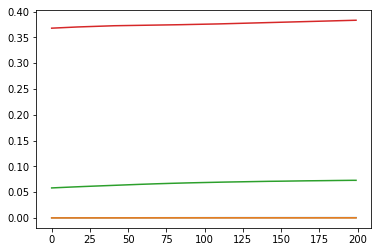

In [104]:
x = range(weights.shape[0])
for i in range(4):
    plt.plot(x, weights[:,i])

In [64]:
inp, conv, prim, seg = sess.run([model.voice_mask_network.mixed_mag, model.voice_mask_network.conv1, model.voice_mask_network.primary_caps, model.voice_mask_network.seg_caps])

In [80]:
tf.trainable_variables()

[<tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/conv2d/kernel:0' shape=(5, 5, 1, 128) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/conv2d/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/primarycaps/W:0' shape=(5, 5, 128, 64) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/primarycaps/b:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/seg_caps/W:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/seg_caps/b:0' shape=(1, 1, 1, 8) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/reconstruction/W:0' shape=(1, 1, 8, 1) dtype=float32_ref>,
 <tf.Variable 'U_Net_Model/SegCaps_CapsNetBasic/reconstruction/b:0' shape=(1, 1, 1, 1) dtype=float32_ref>]

In [88]:
sess.run('U_Net_Model/SegCaps_CapsNetBasic/seg_caps/W:0')

array([[[[nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan]]]], dtype=float32)